In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import os
os.chdir('/home/jma819/post_cnmfe_analysis/')
import python_utils_jjm as utils_jjm
import python_utils_jjm as utils_jjm
import dlc_utils
from sklearn.preprocessing import MinMaxScaler
import scipy.spatial.distance as dist
import itertools
import math
import warnings
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import av
from multiprocessing import Pool
import functools
import glob
plt.rcParams['animation.ffmpeg_path']='/home/jma819/.conda/envs/caiman/bin/ffmpeg'
warnings.filterwarnings(action='once')

In [2]:
reload(utils_jjm)
reload(dlc_utils)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:30.849498. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'dlc_utils' from '/home/jma819/post_cnmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/cnmfe_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_key.csv')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:31.387954. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
# '27-Feb_17_33_59_out.mat' '28-Feb_16_21_21_out.mat' '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat' throwing error
wt_CNMFE_files = ['12-Mar_14_05_31_out.mat' ,'10-Mar_21_30_19_out.mat', '29-Jan_12_35_06_out.mat','30-Mar_20_39_05_out.mat', 
                  '30-Mar_20_45_16_out.mat', 
                  '22-Mar_22_52_02_out.mat', '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '25-Mar_13_27_27_out.mat',
                  '27-Feb_17_33_59_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', 
                  '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat', '10-Mar_21_30_19_out.mat']
#'12-Mar_12_52_13_out.mat',
ko_CNMFE_files = ['11-Mar_18_08_19_out.mat', '11-Mar_16_27_44_out.mat','31-Jan_01_43_49_out.mat',
                  '31-Jan_00_12_24_out.mat','31-Mar_13_28_15_out.mat',  '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', 
                  '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                  '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:32.207337. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [5]:
#create dictionary to store tracking info
#do this for all wt and ko sessions, parse out later in individual analysis functions
tracking_files = ['/projects/b1118/behaviorvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key, 'unsmoothed_02212021') 
                  for fname in wt_CNMFE_files+ko_CNMFE_files] 

cnmfe_dict_key = {'/projects/b1118/behaviorvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key, 'unsmoothed_02212021'):
                  str(cnmfe_base_dir+fname) for fname in wt_CNMFE_files for fname in wt_CNMFE_files+ko_CNMFE_files}

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:37.349912. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


# compiling/binning velocity across wt and ko sessions 

In [6]:
#load all tracking_files for velocity binning
all_session_names = [file.split('/')[-2] for file in list(cnmfe_dict_key.keys())]

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:38.721975. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [7]:
#combine all dlc openfield output files and convert to timedelta index
velocity_data = pd.concat([pd.read_csv(file).drop(['Unnamed: 0', 'Unnamed: 0.1',  'index'], axis=1) 
                           for file in list(cnmfe_dict_key.keys())], keys=all_session_names)
velocity_data_td = pd.concat([velocity_data.loc[session].set_index(pd.to_timedelta(np.linspace(velocity_data.loc[session]['sysClock'].iloc[0], 
                    velocity_data.loc[session]['sysClock'].iloc[-1]/1000, len(velocity_data.loc[session])), unit='s'), drop=True) 
                   for session in all_session_names], keys=all_session_names)
velocity_data_td.to_hdf('/projects/b1118/miniscope/analysis/event_analysis/compiled_velocity_all_sessions.h5',
                                              key='velocity_tracking_data', mode='w')

#downsample for binning 
new_sampling_interval = .2
V_df = pd.concat([velocity_data_td.loc[session].resample(str(new_sampling_interval)+'S').max() 
                  for session in all_session_names], keys=all_session_names)
#V_df.to_hdf('/projects/b1118/miniscope/analysis/event_analysis/compiled_velocity_all_sessions.h5',
#                                              key='velocity_tracking_resampled', mode='w', format='table')
V_df['velocity_bins']= pd.cut(V_df['tail_base'], bins=10)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:15:39.432223. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


FileNotFoundError: [Errno 2] No such file or directory: '/projects/b1118/behaviorvideos/GRIN039_H12_M33_S29/GRIN039_H12_M33_S29_dlc_tracking_foranalysis_unsmoothed_02212021.csv'

In [8]:
##save all spatial information to hdf 
h5_output = h5py.File('/projects/b1118/miniscope/analysis/spatial_data/spatial_components_test.h5', 'w')
for CNMFE_file, tracking_file in zip(list(cnmfe_dict_key.values()), cnmfe_dict_key.keys()):
    com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
    h5_output.create_dataset(str(tracking_file.split('/')[-2]), data=spatial_components)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-22 10:43:09.705319. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [9]:
h5_output.keys()
#len(list(h5_output.keys()))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-22 10:44:36.324104. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<KeysViewHDF5 ['GRIN009_H13_M59_S14', 'GRIN011_H10_M19_S59', 'GRIN012_H16_M57_S23', 'GRIN012_H17_M32_S17', 'GRIN012_H17_M46_S35', 'GRIN013_H13_M33_S54', 'GRIN018_H16_M13_S53', 'GRIN018_H17_M41_S43', 'GRIN026_H16_M35_S34', 'GRIN027_H13_M29_S44', 'GRIN032_H16_M49_S22', 'GRIN032_H17_M30_S22', 'GRIN033_H13_M42_S33', 'GRIN033_H14_M34_S32', 'GRIN034_H15_M28_S2', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M31_S20', 'GRIN035_H13_M50_S58', 'GRIN035_H14_M40_S34', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN038_H15_M39_S40', 'GRIN039_H12_M26_S54', 'GRIN039_H12_M33_S29', 'GRIN039_H14_M8_S53', 'GRIN041_H12_M54_S49']>

In [10]:
h5_output.close()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-22 10:44:47.272630. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [11]:
# change to individually saving files
CNMFE_file = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/29-Jan_12_35_06_out.mat'
tracking_file = '/projects/b1118/behaviorvideos/GRIN039_H12_M26_S54/GRIN039_H12_M26_S54_dlc_tracking_foranalysis_unsmoothed_02212021.csv'
cell_fluorescence = sio.loadmat(CNMFE_file)
C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
tracking_file.split('/')[-2]

#C_normalized.to_hdf('/projects/b1118/miniscope/analysis/compiled_data/C_normalized/C_normalized_timedelta_wt.h5', key=tracking_file.split('/')[-2], mode='a')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-09 19:15:13.102839. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


'GRIN039_H12_M26_S54'

In [12]:
#C_normalized.to_hdf('/projects/b1118/miniscope/analysis/compiled_data/C_normalized/C_normalized_timedelta_wt.h5', key=tracking_file.split('/')[-2], mode='a')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-09 19:15:17.772154. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


# loading sessions by group 

In [9]:
cnmfe_dict_key

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-29 16:45:14.631634. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


{'/projects/b1118/behaviorvideos/GRIN039_H12_M33_S29/GRIN039_H12_M33_S29_dlc_tracking_foranalysis_unsmoothed_02212021.csv': '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/12-Mar_14_05_31_out.mat',
 '/projects/b1118/behaviorvideos/GRIN039_H14_M8_S53/GRIN039_H14_M8_S53_dlc_tracking_foranalysis_unsmoothed_02212021.csv': '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/10-Mar_21_30_19_out.mat',
 '/projects/b1118/behaviorvideos/GRIN039_H12_M26_S54/GRIN039_H12_M26_S54_dlc_tracking_foranalysis_unsmoothed_02212021.csv': '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/29-Jan_12_35_06_out.mat',
 '/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/GRIN013_H13_M33_S54_dlc_tracking_foranalysis_unsmoothed_02212021.csv': '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/30-Mar_20_39_05_out.mat',
 '/projects/b1118/behaviorvideos/GRIN027_H13_M29_S44/GRIN027_H13_M29_S44_dlc_tracking_foranalysis_unsmooth

In [10]:
grouped_raw_data = {}
success = []
failed = []
#now storing CNMFE file paths as values in dictionary with tracking files as keys
for CNMFE_file, tracking_file in zip(list(cnmfe_dict_key.values()), cnmfe_dict_key.keys()):
    print(CNMFE_file)
    print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        velocity_data = pd.read_csv(tracking_file)
        velocity_data.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
        velocity_data_td = velocity_data.set_index(pd.to_timedelta(np.linspace(velocity_data['sysClock'].iloc[0], 
               velocity_data['sysClock'].iloc[-1]/1000,
               len(velocity_data)), unit='s'), drop=True) 
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored,
                                                          'velocity_data' : velocity_data_td, 'com' : com_df, 'spatial_components' : spatial_components, 
                                                          'cell_contours': cell_contours, 'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-29 16:45:15.845989. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/12-Mar_14_05_31_out.mat
/projects/b1118/behaviorvideos/GRIN039_H12_M33_S29/GRIN039_H12_M33_S29_dlc_tracking_foranalysis_unsmoothed_02212021.csv
/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/10-Mar_21_30_19_out.mat
/projects/b1118/behaviorvideos/GRIN039_H14_M8_S53/GRIN039_H14_M8_S53_dlc_tracking_foranalysis_unsmoothed_02212021.csv
/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/29-Jan_12_35_06_out.mat
/projects/b1118/behaviorvideos/GRIN039_H12_M26_S54/GRIN039_H12_M26_S54_dlc_tracking_foranalysis_unsmoothed_02212021.csv
/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/30-Mar_20_39_05_out.mat
/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/GRIN013_H13_M33_S54_dlc_tracking_foranalysis_unsmoothed_02212021.csv
/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/30-Mar_20_45_16_out.mat
/projects/b1118/behaviorvideos/GRIN02

## save to import into MATLAB functions 

In [9]:
success

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 11:01:14.344124. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[('GRIN039_H12_M33_S29', '12-Mar_14_05_31_out.mat'),
 ('GRIN039_H14_M8_S53', '10-Mar_21_30_19_out.mat'),
 ('GRIN039_H12_M26_S54', '29-Jan_12_35_06_out.mat'),
 ('GRIN013_H13_M33_S54', '30-Mar_20_39_05_out.mat'),
 ('GRIN027_H13_M29_S44', '30-Mar_20_45_16_out.mat'),
 ('GRIN033_H14_M34_S32', '22-Mar_22_52_02_out.mat'),
 ('GRIN033_H13_M42_S33', '28-Feb_16_10_05_out.mat'),
 ('GRIN032_H17_M30_S22', '27-Feb_17_32_15_out.mat'),
 ('GRIN034_H15_M28_S2', '25-Mar_13_27_27_out.mat'),
 ('GRIN026_H16_M35_S34', '27-Feb_17_33_59_out.mat'),
 ('GRIN032_H16_M49_S22', '28-Feb_16_21_21_out.mat'),
 ('GRIN034_H16_M13_S22', '25-Mar_14_22_02_out.mat'),
 ('GRIN034_H19_M0_S18', '25-Mar_14_22_44_out.mat'),
 ('GRIN035_H13_M50_S58', '26-Mar_18_33_55_out.mat'),
 ('GRIN035_H13_M31_S20', '27-Mar_00_26_12_out.mat'),
 ('GRIN035_H14_M40_S34', '27-Mar_00_48_46_out.mat'),
 ('GRIN038_H15_M39_S40', '11-Mar_18_08_19_out.mat'),
 ('GRIN038_H11_M57_S0', '11-Mar_16_27_44_out.mat'),
 ('GRIN038_H13_M37_S23', '31-Jan_01_43_49_out.mat'

In [13]:
## for spatial clustering start by using z scored data on whole trace as input to event detection function, then try with z score based 
#on rest or other periods
C_traces_filtered_for_analysis = {}
com_filtered_for_analysis = {}
##remove small cells 
for session in list(grouped_raw_data.keys()):
    # get indicies of small cells 
    cells_to_drop = np.array([int(cell) for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    C_traces_filtered = grouped_raw_data[session]['C_normalized_z_scored'].drop(cells_to_drop, axis=1)
    
    C_traces_filtered_for_analysis[session] = C_traces_filtered.drop('msCamFrame', axis=1)
    com_filtered_for_analysis[session] = grouped_raw_data[session]['com'].drop(cells_to_drop, axis=0).transpose()

# sets sampling interval to 5Hz to correspond to behavior data 
C_z_score_df = pd.concat([C_traces_filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(C_traces_filtered_for_analysis.keys())], axis=1, keys=list(C_traces_filtered_for_analysis.keys()))

# after downsampling convert back to regular index, timedelta is behaving oddly 
C_z_score_df_reindexed = pd.concat([C_z_score_df[session].reset_index(drop=True) 
                                    for session in list(set(C_z_score_df.columns.get_level_values(0)))], axis=1, keys=list(set(C_z_score_df.columns.get_level_values(0))))
# drop columns with all nan values
C_z_score_df_reindexed.dropna(axis=1, how='all', inplace=True)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-14 18:12:03.284389. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [15]:
## save each session csv file individually for loading into MATLAB
# using MATLAB readtable function, which will create variable names from column header 
save_directory = '/projects/b1118/miniscope/analysis/spatial_data/spatial_clusting/jones_script_analysis/'
for session in list(set(C_z_score_df_reindexed.columns.get_level_values(0))):
    C_z_score_df_reindexed[session].to_csv(save_directory+session+'_C_traces_filtered.csv')
    com_filtered_for_analysis[session].to_csv(save_directory+session+'_com_filtered.csv')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-14 18:12:18.433051. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [2]:
grouped_raw_data.keys()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 22:35:15.824512. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'grouped_raw_data' is not defined

In [ ]:
#scale information
sessions_with_scale = {{'GRIN039_H12_M33_S29';1.04};{'GRIN039_H14_M8_S53';1.04};{'GRIN039_H12_M26_S54';1.04};{'GRIN013_H13_M33_S54';1.11};
                       {'GRIN027_H13_M29_S44';1.11};{'GRIN033_H14_M34_S32';1.11};{'GRIN033_H13_M42_S33';1.11};{'GRIN032_H17_M30_S22';1.11};
                       {'GRIN034_H15_M28_S2';1.04};{'GRIN026_H16_M35_S34';1.11};{'GRIN032_H16_M49_S22';1.11};{'GRIN034_H16_M13_S22';1.04};
                       {'GRIN034_H19_M0_S18';1.04};{'GRIN035_H13_M50_S58';1.11};{'GRIN035_H13_M31_S20';1.11};{'GRIN035_H14_M40_S34';1.11};
                       {'GRIN038_H15_M39_S40';1.04};{'GRIN038_H11_M57_S0';1.04};{'GRIN038_H13_M37_S23';1.04};{'GRIN041_H12_M54_S49';1.04};
                       {'GRIN009_H13_M59_S14';1.04};{'GRIN018_H17_M41_S43';1.04};{'GRIN018_H16_M13_S53';1.04};{'GRIN011_H10_M19_S59';0.98};
                       {'GRIN012_H17_M46_S35';1.11};{'GRIN012_H17_M32_S17';1.11};{'GRIN012_H16_M57_S23';1.11}}

In [56]:
"';'".join(list(grouped_raw_data.keys()))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 16:09:11.828037. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


"GRIN039_H12_M33_S29';'GRIN039_H14_M8_S53';'GRIN039_H12_M26_S54';'GRIN013_H13_M33_S54';'GRIN027_H13_M29_S44';'GRIN033_H14_M34_S32';'GRIN033_H13_M42_S33';'GRIN032_H17_M30_S22';'GRIN034_H15_M28_S2';'GRIN026_H16_M35_S34';'GRIN032_H16_M49_S22';'GRIN034_H16_M13_S22';'GRIN034_H19_M0_S18';'GRIN035_H13_M50_S58';'GRIN035_H13_M31_S20';'GRIN035_H14_M40_S34';'GRIN038_H15_M39_S40';'GRIN038_H11_M57_S0';'GRIN038_H13_M37_S23';'GRIN041_H12_M54_S49';'GRIN009_H13_M59_S14';'GRIN018_H17_M41_S43';'GRIN018_H16_M13_S53';'GRIN011_H10_M19_S59';'GRIN012_H17_M46_S35';'GRIN012_H17_M32_S17';'GRIN012_H16_M57_S23"

In [36]:
##save movement regions for spatial clustering analysis
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5')
keys=h5file.keys()
h5file.close()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 15:30:35.381810. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [37]:
moving_events_by_session = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5', key=key_idx) for key_idx in keys}

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 15:30:37.727881. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()


In [101]:
save_directory = '/projects/b1118/miniscope/analysis/spatial_data/spatial_clusting/jones_script_analysis/moving_regions/'
for session in list(moving_events_by_session.keys()):
    moving_reindexed=moving_events_by_session[session].loc['z_scored_movement_regions'].reset_index(drop=True)
    moving_reindexed.to_csv(save_directory+session+'movement_regions_C_traces_filtered.csv')
    #rest_reindexed=moving_events_by_session[session].loc['z_scored_rest_regions'].reset_index(drop=True)
    #rest_reindexed.to_csv(save_directory+session+'rest_regions_C_traces_filtered.csv')
    

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 16:41:49.504393. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [206]:
save_directory = '/projects/b1118/miniscope/analysis/spatial_data/spatial_clusting/jones_script_analysis/rest_regions/'
for session in list(moving_events_by_session.keys()):
    rest_reindexed=moving_events_by_session[session].loc['z_scored_rest_regions'].reset_index(drop=True)
    rest_reindexed.to_csv(save_directory+session+'rest_regions_C_traces_filtered.csv')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-15 18:12:35.427326. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


# loading files analyzed by MATLAB scripts 

In [8]:
def concat_by_mouse(df_unsorted):
    sorted_by_mouse = {mouse:[] for mouse in list(set([session[0:7] for session in list(df_unsorted.columns)]))}
    for mouse in sorted_by_mouse.keys():
        for session in list(df_unsorted.columns):
            if session[0:7] == mouse:
                sorted_by_mouse[mouse].append(df_unsorted[session])
    concat_by_mouse_df = pd.DataFrame({mouse:pd.concat(sorted_by_mouse[mouse], axis=1).mean(axis=1) for mouse in list(sorted_by_mouse.keys())})
    return(concat_by_mouse_df)
    

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:03.484711. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [9]:
def load_norm_jaccards_from_MATLAB(data_dir, reg_exp, sd_threshold):
    normlBinnedCellJaccards = {}
    for file in glob.glob(data_dir+'*'+reg_exp+'*'):
        normlBinnedCellJaccards[file.split('/')[-1].rstrip(reg_exp+str(sd_threshold)+'.csv')] = np.genfromtxt(file, delimiter=',')
    return(normlBinnedCellJaccards)

def concat_by_group(ungrouped_data, genotype_sessions):
    normlBinnedCellJaccards_df_group = pd.concat([pd.DataFrame({k:ungrouped_data[k]}) 
                                                          for k in ungrouped_data.keys() 
                                           if k in genotype_sessions], axis=1).replace([np.inf, -np.inf], np.nan)
    return(normlBinnedCellJaccards_df_group)
    

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:04.180160. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [10]:
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 
               'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33','GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 
               'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']

ko_sessions = ['GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN018_H17_M41_S43',
 'GRIN018_H16_M13_S53', 'GRIN011_H10_M19_S59', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:04.933794. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [11]:
#data params to load 
data_dir = '/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/jones_script_analysis/'
sd_threshold = 2.5
reg_exp = '_normlBinnedCellJaccards__'

normlBinnedCellJaccards = load_norm_jaccards_from_MATLAB(data_dir, reg_exp, sd_threshold)
normlBinnedCellJaccards_df_wt = concat_by_group(normlBinnedCellJaccards, wt_sessions)
normlBinnedCellJaccards_df_ko = concat_by_group(normlBinnedCellJaccards, ko_sessions)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:05.544177. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [12]:
mean_to_plot_wt = normlBinnedCellJaccards_df_wt.mean(axis=1)
std_error_wt = normlBinnedCellJaccards_df_wt.std(axis=1)/math.sqrt(len(wt_sessions))
mean_to_plot_ko = normlBinnedCellJaccards_df_ko.mean(axis=1)
std_error_ko = normlBinnedCellJaccards_df_ko.std(axis=1)/math.sqrt(len(ko_sessions))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:09.671904. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [13]:
normlBinnedCellJaccards_df_wt

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:10.268121. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,GRIN027_H13_M29_S44,GRIN026_H16_M35_S34,GRIN035_H13_M50_S58,GRIN033_H13_M42_S33,GRIN039_H12_M26_S54,GRIN039_H12_M33_S29,GRIN013_H13_M33_S54,GRIN034_H19_M0_S18,GRIN035_H13_M31_S20,GRIN039_H14_M8_S53,GRIN035_H14_M40_S34
0,19.4510,18.2240,25.9380,10.0660,27.9220,17.59700,20.4730,42.4750,22.3960,10.30300,19.8580
1,12.7810,10.5770,18.4640,6.8833,17.7880,4.38030,15.7310,22.2030,19.0470,5.06920,16.6720
2,9.8242,8.5073,15.6460,5.9866,9.6533,3.19210,10.8130,15.1510,11.1080,4.90100,11.4540
3,8.4808,7.5775,10.8270,5.2710,9.2673,7.01740,8.1879,19.4330,10.1640,3.46690,8.3636
4,7.2266,6.4577,9.5955,5.1633,5.4024,5.91040,9.6045,15.1570,9.3477,3.02050,8.0894
5,6.5289,5.8943,8.1900,4.9446,3.5441,3.67550,7.8938,12.1180,8.2728,1.78390,5.3303
6,6.2049,5.5826,8.3418,5.1857,4.1995,2.71930,9.4256,9.9221,7.7817,1.82700,4.9772
7,6.2193,5.0373,7.7214,4.7522,3.7038,2.54300,8.5733,9.3754,7.8194,1.47120,4.0891
8,5.2849,5.4557,7.1906,4.6568,4.4502,1.92150,8.1043,9.2433,7.2935,1.48750,3.7597
9,5.4574,5.2491,6.4894,4.1741,3.0367,1.91750,6.2151,11.4720,7.4361,1.18840,4.6385


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-10-30 16:16:33.497635. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


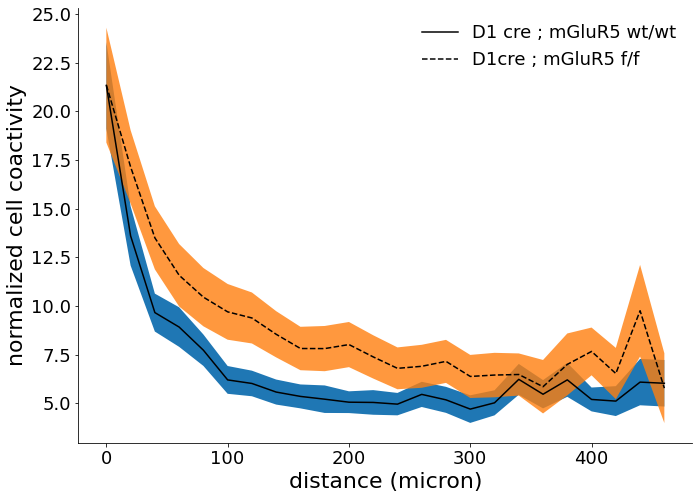

In [15]:
## by session

fig, (ax) = plt.subplots(1, 1, figsize=(11, 8))
                       
plt.rcParams.update({'font.size': 22})
bin_scale = 20
plt.plot(list(mean_to_plot_wt.index*bin_scale), mean_to_plot_wt, color='k', label='D1 cre ; mGluR5 wt/wt')
plt.fill_between(list(mean_to_plot_wt.index*bin_scale), mean_to_plot_wt+std_error_wt, 
                 mean_to_plot_wt-std_error_wt)
plt.plot(list(mean_to_plot_ko.index*bin_scale), mean_to_plot_ko, color='k', label='D1cre ; mGluR5 f/f', linestyle='dashed')
plt.fill_between(list(mean_to_plot_ko.index*bin_scale), mean_to_plot_ko+std_error_ko, 
                 mean_to_plot_ko-std_error_ko, alpha=0.8)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

plt.ylabel('normalized cell coactivity')
plt.xlabel('distance (micron)')

plt.legend(loc=1, fontsize=18, frameon=False)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels


plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_combined_over_sessions_'+str(sd_threshold)+
            '.pdf', transparent=True)
plt.show()

In [14]:
by_mouse_wt = concat_by_mouse(normlBinnedCellJaccards_df_wt)
by_mouse_wt_mean = by_mouse_wt.mean(axis=1)
by_mouse_wt_std = by_mouse_wt.std(axis=1)/math.sqrt(len(list(by_mouse_wt.columns)))
by_mouse_ko = concat_by_mouse(normlBinnedCellJaccards_df_ko)
by_mouse_ko_mean = by_mouse_ko.mean(axis=1)
by_mouse_ko_std = by_mouse_ko.std(axis=1)/math.sqrt(len(list(by_mouse_ko.columns)))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-05-06 11:12:07.807250. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-05-06 11:23:42.428553. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


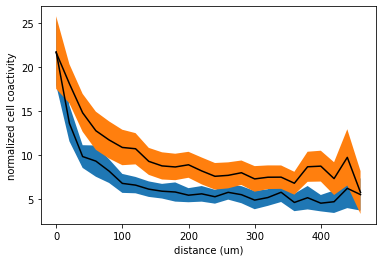

In [19]:
## by mouse
fig = plt.figure()
plt.plot(list(by_mouse_wt_mean.index*bin_scale), by_mouse_wt_mean, color='k')
plt.fill_between(list(by_mouse_wt_mean.index*bin_scale), by_mouse_wt_mean+by_mouse_wt_std, 
                 by_mouse_wt_mean-by_mouse_wt_std)
plt.plot(list(by_mouse_ko_mean.index*bin_scale), by_mouse_ko_mean, color='k')
plt.fill_between(list(by_mouse_ko_mean.index*bin_scale), by_mouse_ko_mean+by_mouse_ko_std, 
                 by_mouse_ko_mean-by_mouse_ko_std)
plt.ylabel('normalized cell coactivity')
plt.xlabel('distance (um)')
plt.draw()
fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_combined_over_mice_'+str(sd_threshold)+
            '.svg', bbox_inches='tight', format='svg', transparent=True)
plt.show()

In [ ]:
# save data to svg file for plotting later 

In [65]:
plot_data = pd.DataFrame({'wt_mean':by_mouse_wt_mean, 'ko_mean':by_mouse_ko_mean, 'wt_sem':by_mouse_wt_std, 'ko_sem':by_mouse_ko_std,
                         'distance um':np.array([x for x in range(0, len(by_mouse_wt_mean.index)*bin_scale, bin_scale)])})
plot_data = plot_data.set_index('distance um', drop=True)
plot_data.to_csv('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_combined_over_mice_.csv')

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-05-06 11:43:20.286539. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
plot_data

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-05-06 11:43:21.638678. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,wt_mean,ko_mean,wt_sem,ko_sem
distance um,,,,
0,21.718143,21.636772,3.767724,4.113461
20,13.616495,18.105580,2.034305,2.217239
40,9.847652,14.807760,1.286994,2.146568
60,9.331276,12.773550,1.768716,2.162644
80,8.199676,11.728817,1.344710,2.105709
100,6.806448,10.878900,1.074159,2.009003
120,6.609962,10.732281,0.925516,1.769708
140,6.153352,9.301733,0.878639,1.528495
160,5.920857,8.789250,0.830202,1.539379


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-05-06 11:12:33.303341. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


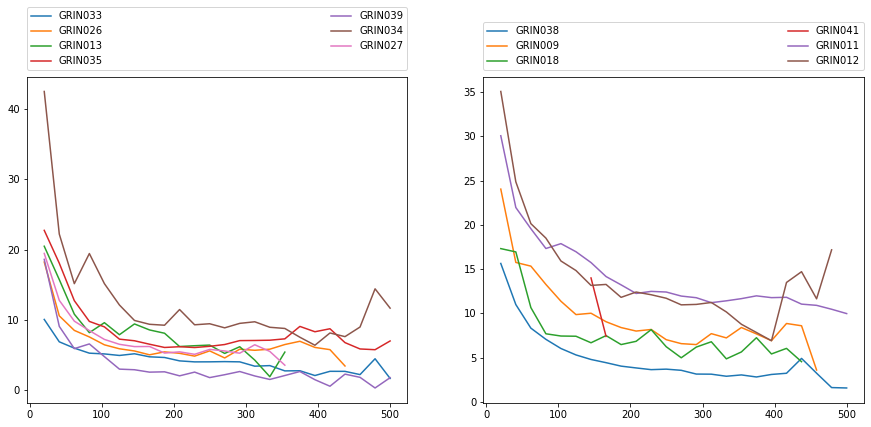

In [16]:
## individual mice  
genotype_compiled = by_mouse_wt
genotype_compiled_ko = by_mouse_ko

fig = plt.figure()
plt.subplot(1, 2, 1)

for session in list(genotype_compiled.columns):
    bin_vector = np.linspace(20, 500, len(genotype_compiled[session].values))
    plt.plot(bin_vector, genotype_compiled[session].values, label=session)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

fig.set_size_inches(15, 6)

plt.subplot(1, 2, 2)

for session in list(genotype_compiled_ko.columns):
    bin_vector = np.linspace(20, 500, len(genotype_compiled_ko[session].values))
    plt.plot(bin_vector, genotype_compiled_ko[session].values, label=session)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

fig.set_size_inches(15, 6)
#fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_indiv_bymouse_'+str(sd_threshold)+
#            '.pdf', transparent=True)
plt.show()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 19:05:46.097239. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


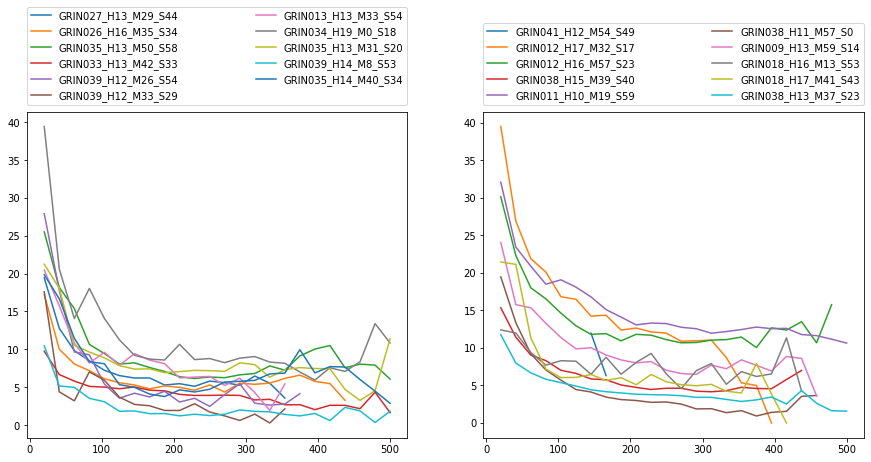

In [13]:
## individual session  
genotype_compiled = normlBinnedCellJaccards_df_wt
genotype_compiled_ko = normlBinnedCellJaccards_df_ko

fig = plt.figure()
plt.subplot(1, 2, 1)

for session in list(genotype_compiled.columns):
    bin_vector = np.linspace(20, 500, len(genotype_compiled[session].values))
    plt.plot(bin_vector, genotype_compiled[session].values, label=session)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

fig.set_size_inches(15, 6)

plt.subplot(1, 2, 2)

for session in list(genotype_compiled_ko.columns):
    bin_vector = np.linspace(20, 500, len(genotype_compiled_ko[session].values))
    plt.plot(bin_vector, genotype_compiled_ko[session].values, label=session)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

fig.set_size_inches(15, 6)
fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_indiv_bysession'+str(sd_threshold)+
            '.pdf', transparent=True)
plt.show()

## compare movement to rest

In [83]:
#data params to load 
data_dir = '/projects/b1118/miniscope/analysis/spatial_data/spatial_clustering/jones_script_analysis/rest_regions/'
sd_threshold = 2.5
reg_exp = '_normlBinnedCellJaccards__'

normlBinnedCellJaccards_movement = load_norm_jaccards_from_MATLAB(data_dir, reg_exp, sd_threshold)
normlBinnedCellJaccards_df_wt_movement = concat_by_group(normlBinnedCellJaccards_movement, wt_sessions)
normlBinnedCellJaccards_df_ko_movement = concat_by_group(normlBinnedCellJaccards_movement, ko_sessions)

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 13:02:44.180580. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
mean_to_plot_movement_wt = normlBinnedCellJaccards_df_wt_movement.mean(axis=1)
std_error_movement_wt = normlBinnedCellJaccards_df_wt_movement.std(axis=1)/math.sqrt(len(wt_sessions))
mean_to_plot_movement_ko = normlBinnedCellJaccards_df_ko_movement.mean(axis=1)
std_error_movement_ko = normlBinnedCellJaccards_df_ko_movement.std(axis=1)/math.sqrt(len(ko_sessions))

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 13:02:44.815286. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 13:02:45.422130. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


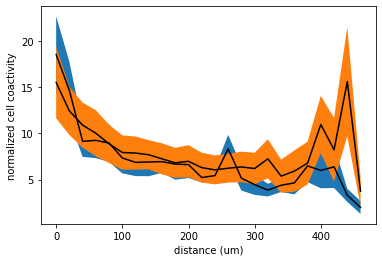

In [85]:
## by session
plt.figure()
bin_scale = 20
plt.plot(list(mean_to_plot_movement_wt.index*bin_scale), mean_to_plot_movement_wt, color='k')
plt.fill_between(list(mean_to_plot_movement_wt.index*bin_scale), mean_to_plot_movement_wt+std_error_movement_wt, 
                 mean_to_plot_movement_wt-std_error_movement_wt)
plt.plot(list(mean_to_plot_movement_ko.index*bin_scale), mean_to_plot_movement_ko, color='k')
plt.fill_between(list(mean_to_plot_movement_ko.index*bin_scale), mean_to_plot_movement_ko+std_error_movement_ko, 
                 mean_to_plot_movement_ko-std_error_movement_ko)
plt.ylabel('normalized cell coactivity')
plt.xlabel('distance (um)')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_combined_over_sessions_'+str(sd_threshold)+
#            '.pdf', transparent=True)
plt.show()

/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/jupyter_client/jsonutil.py:64: DeprecationWarning: Interpreting naive datetime as local 2021-03-16 13:00:54.407223. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/jma819/.conda/envs/caiman_with_tables/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


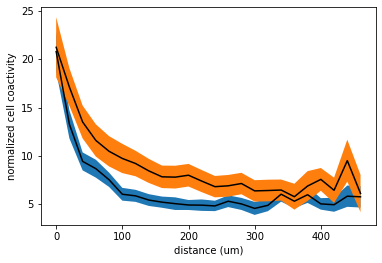

In [67]:
## by session
plt.figure()
bin_scale = 20
plt.plot(list(mean_to_plot_wt.index*bin_scale), mean_to_plot_wt, color='k')
plt.fill_between(list(mean_to_plot_wt.index*bin_scale), mean_to_plot_wt+std_error_wt, 
                 mean_to_plot_wt-std_error_wt)
plt.plot(list(mean_to_plot_ko.index*bin_scale), mean_to_plot_ko, color='k')
plt.fill_between(list(mean_to_plot_ko.index*bin_scale), mean_to_plot_ko+std_error_ko, 
                 mean_to_plot_ko-std_error_ko)
plt.ylabel('normalized cell coactivity')
plt.xlabel('distance (um)')
#plt.savefig('/projects/b1118/miniscope/analysis/summaryfigures/coactivity_data_combined_over_sessions_'+str(sd_threshold)+
#            '.pdf', transparent=True)
plt.show()